In [1]:
from utils import (
    calculate_two_peaks_probability,
    sig,
    sigfit,
    TwoFlashesProcessingStrategy,
    TwoFlashesProcessingStrategy_Explore,
)

## Experimental Data

In [2]:
import pandas as pd

# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100

# Average data by group
avg_data = data.groupby(["Group", "Delay"])["Flashes"].aggregate(["mean"])
avg_data.reset_index(inplace=True)
avg_data.rename(columns={"mean": "Flashes (%)"}, inplace=True)
avg_data["Delay"] = avg_data.Delay.astype(float)

# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=14.6033, b=61.7941, c=86.2012, d=-27.569
        )
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=15.045, b=66.7106, c=59.806, d=-26.553
        )
        df_lspq = group[1]

dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

## TODO double check fit values

,Group,Delay,Flashes (%),Fit
0,H-SPQ,108.0,35.357143,33.884199
1,H-SPQ,120.0,30.357143,28.623599
2,H-SPQ,132.0,27.142857,24.465345
3,H-SPQ,144.0,18.928571,21.365804
4,H-SPQ,156.0,18.214286,19.155035


<Axes: xlabel='Delay', ylabel='Flashes (%)'>

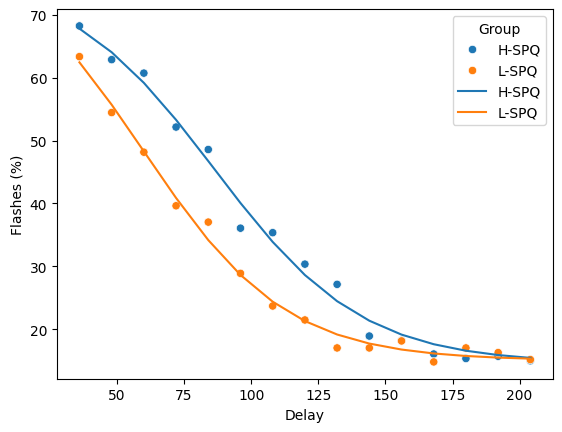

In [3]:
import seaborn as sns

sns.scatterplot(data=dataset, x="Delay", y="Flashes (%)", hue="Group")
sns.lineplot(data=dataset, x="Delay", y="Fit", hue="Group")

<Axes: xlabel='Delay', ylabel='Fit'>

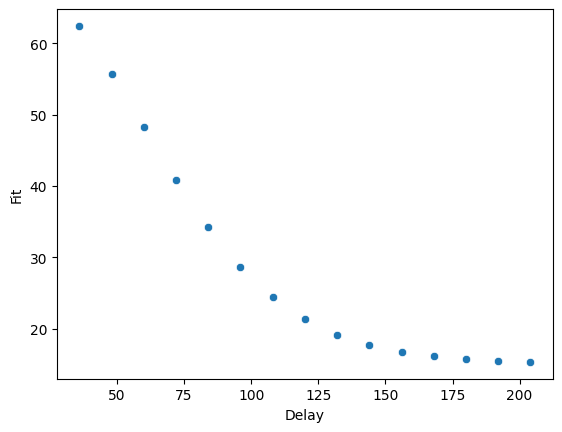

In [4]:
# Data to fit
lspq_data = dataset.query("Group == 'L-SPQ'").sort_values(by=["Delay"])["Fit"].values
soas = dataset.query("Group == 'L-SPQ'").sort_values(by=["Delay"])["Delay"].values
sns.scatterplot(data=dataset.query("Group == 'L-SPQ'"), y="Fit", x="Delay")

## Fitting

In [ ]:
from skneuromsi.neural import Paredes2022
from skneuromsi.sweep import ParameterSweep
from scipy.optimize import differential_evolution
import multiprocess as mp
import numpy as np


def two_flashes_job(a_tau, v_tau, cm_weight):

    model = Paredes2022(
        time_range=(0, 500),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, 6),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=10,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=0.5,
        lateral_inhibition=0.4,
        cross_modal_weight=cm_weight,
        feedback_weight=0,
        feedforward_weight=0,
    )

    return res


def baseline_cost(theta):

    exp_data = lspq_data
    model_data = two_flashes_job(a_tau=theta[0], v_tau=theta[1], cm_weight=theta[2])
    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    return cost


bounds = [(6, 20), (6.25, 60), (0.001, 0.05)]

with mp.Pool(12) as pool:
    baseline_fit_res = differential_evolution(
        baseline_cost,
        bounds,
        disp=True,
        updating="deferred",
        workers=pool.map,
        polish=False,
    )

differential_evolution step 1: f(x)= 13.199831883115923
differential_evolution step 2: f(x)= 13.075242217209212
differential_evolution step 3: f(x)= 13.07037960907006
differential_evolution step 4: f(x)= 12.823535456464693
differential_evolution step 5: f(x)= 12.823535456464693
differential_evolution step 6: f(x)= 12.791040430751027
differential_evolution step 7: f(x)= 12.775963893942228
differential_evolution step 8: f(x)= 12.766216130470408
differential_evolution step 9: f(x)= 12.740431753018722
differential_evolution step 10: f(x)= 12.740431753018722
differential_evolution step 11: f(x)= 12.721479562518097
differential_evolution step 12: f(x)= 12.721479562518097
differential_evolution step 13: f(x)= 12.721479562518097
differential_evolution step 14: f(x)= 12.721479562518097
differential_evolution step 15: f(x)= 12.721479562518097
differential_evolution step 16: f(x)= 12.721479562518097
differential_evolution step 17: f(x)= 12.720672853411068
differential_evolution step 18: f(x)= 12.

In [12]:
baseline_fit_res

             message: Optimization terminated successfully.
             success: True
                 fun: 12.71639842872268
                   x: [ 1.981e+01  2.559e+01  4.928e-02]
                 nit: 23
                nfev: 1080
          population: [[ 1.981e+01  2.559e+01  4.928e-02]
                       [ 1.983e+01  2.663e+01  4.772e-02]
                       ...
                       [ 1.958e+01  2.664e+01  4.781e-02]
                       [ 1.953e+01  2.602e+01  4.950e-02]]
 population_energies: [ 1.272e+01  1.274e+01 ...  1.275e+01  1.272e+01]

In [8]:
print(baseline_fit_res)

 message: Optimization terminated successfully.
 success: True
     fun: 0.012437564522264386
       x: [ 1.327e-02  2.423e-01  2.461e+00  6.712e+00  2.356e+01
            1.175e+02]
     nit: 365
    nfev: 32940


## Exploration

In [5]:
from skneuromsi.neural import Paredes2022
from skneuromsi.sweep import ParameterSweep


def two_flashes_job(a_tau, v_tau, m_tau, cm_weight, fb_weight, ff_weight):

    model = Paredes2022(
        time_range=(0, 600),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=10,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy_Explore(),
    )

    res = sp.run(
        auditory_intensity=2.425,
        visual_intensity=1.375,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=1.6,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
    )

    return res


results_list, two_flashes_res = two_flashes_job(
    a_tau=6.712e00,
    v_tau=2.356e01,
    m_tau=1.175e02,
    cm_weight=1.327e-02,
    fb_weight=2.423e-01,
    ff_weight=2.461e00,
)

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

In [12]:
import numpy as np

sig_soas = np.linspace(soas[0], soas[-1], endpoint=True, num=100)
a, b, c, d = sigfit(soas, two_flashes_res)
print(a, b, c, d)
two_flashes_model_data = sig(sig_soas, a, b, c, d)

15.48222401573115 52.91317541500326 71.27754695603997 -22.54044176781944


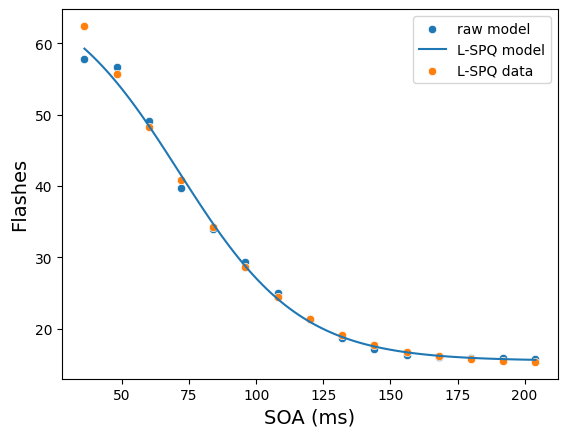

In [13]:
import matplotlib.pyplot as plt

sns.scatterplot(x=soas, y=two_flashes_res, label="raw model")
sns.lineplot(x=sig_soas, y=two_flashes_model_data, label="L-SPQ model")
sns.scatterplot(
    data=dataset.query("Group == 'L-SPQ'"), y="Fit", x="Delay", label="L-SPQ data"
)
plt.ylabel("Flashes", size=14)
plt.xlabel("SOA (ms)", size=14)
plt.show()

## Figure 2

In [14]:
from matplotlib.ticker import ScalarFormatter


def plot_res_per_soa(result_list, position=15):
    fig, axs = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True, dpi=600)
    dashes_dict = {"auditory": "", "visual": "", "multi": (2, 2)}
    idx = -1
    for res in result_list:
        idx += 1
        row, col = idx // 5, idx % 5
        sub_plot = res.plot.linet(
            position=position,
            ax=axs[row, col],
            style="modes",
            dashes=dashes_dict,
            palette=["gray", "black", "gray"],
        )[0]
        sub_plot.get_legend().remove()
        sub_plot.set_title(
            "SOA " + str(int(res.run_parameters.auditory_soa)) + " ms",
            size=12,
            weight="bold",
        )
        sub_plot.set_ylabel("Neural activation", size=11, weight="bold")
        sub_plot.set_xlabel("Time (ms)", size=11, weight="bold")
        sub_plot.set_xlim(0, 60000)
        sub_plot.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
        new_labels = [label.get_text()[:-2] for label in sub_plot.get_xticklabels()]
        if new_labels:
            new_labels[1] = "0"
        sub_plot.set_xticklabels(new_labels)
    handles, legend_labels = sub_plot.get_legend_handles_labels()
    new_legend_labels = ["Auditory", "Visual", "Multisensory"]
    fig.suptitle(None)
    fig.legend(handles, new_legend_labels, loc="center right", borderaxespad=0.75)
    plt.subplots_adjust(right=0.90)
    plt.show()


def plot_res_per_soa_small(result_list, position=15):
    fig, axs = plt.subplots(1, 3, figsize=(14, 3), sharex=True, sharey=True, dpi=600)
    dashes_dict = {"auditory": "", "visual": "", "multi": (2, 2)}
    idx = -1
    for res in result_list[0::7]:
        idx += 1
        col = idx
        sub_plot = res.plot.linet(
            position=position,
            ax=axs[col],
            style="modes",
            dashes=dashes_dict,
        )[0]
        sub_plot.get_legend().remove()
        sub_plot.set_title(
            "SOA " + str(int(res.run_parameters.auditory_soa)) + " ms",
            size=12,
            weight="bold",
        )
        sub_plot.set_ylabel("Neural activation", size=11, weight="bold")
        sub_plot.set_xlabel("Time (ms)", size=11, weight="bold")
        sub_plot.set_xlim(0, 60000)
        sub_plot.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
        new_labels = [label.get_text()[:-2] for label in sub_plot.get_xticklabels()]
        if new_labels:
            new_labels[1] = "0"
        sub_plot.set_xticklabels(new_labels)
    handles, legend_labels = sub_plot.get_legend_handles_labels()
    new_legend_labels = ["Auditory", "Visual", "Multisensory"]
    fig.legend(handles, new_legend_labels, loc="center right", borderaxespad=0.2)
    fig.suptitle(None)
    # fig.savefig("drafts/FIG2.eps", bbox_inches="tight", format="eps")
    plt.subplots_adjust(wspace=0.1)
    plt.show()

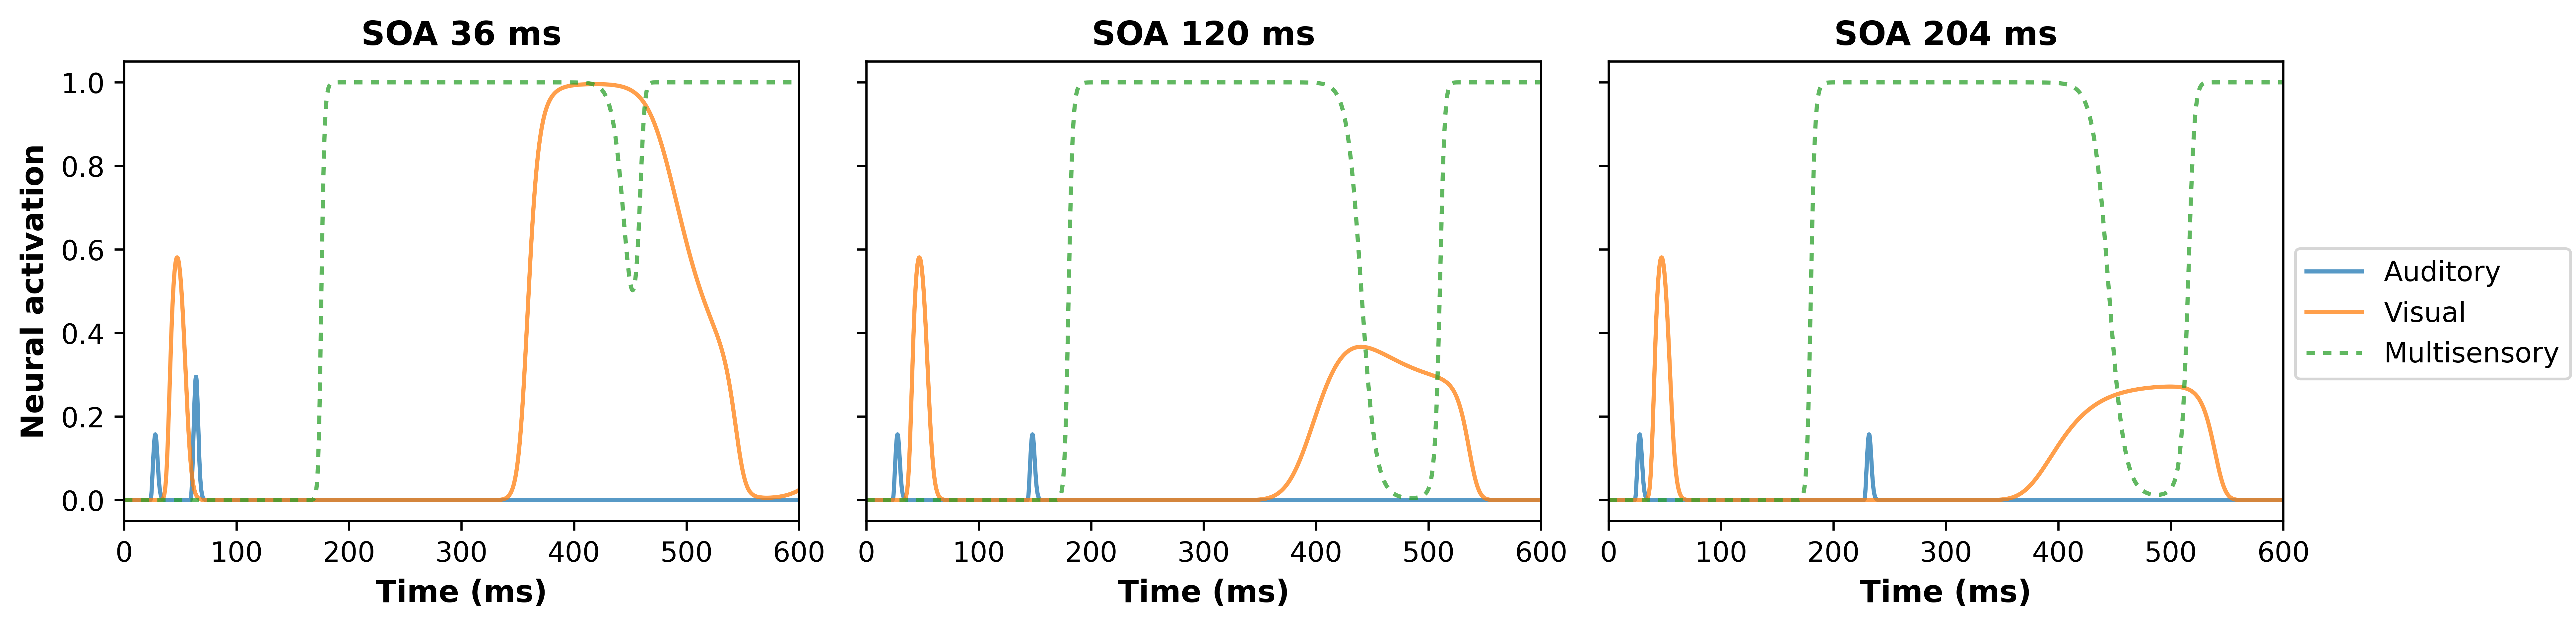

In [15]:
plot_res_per_soa_small(results_list)

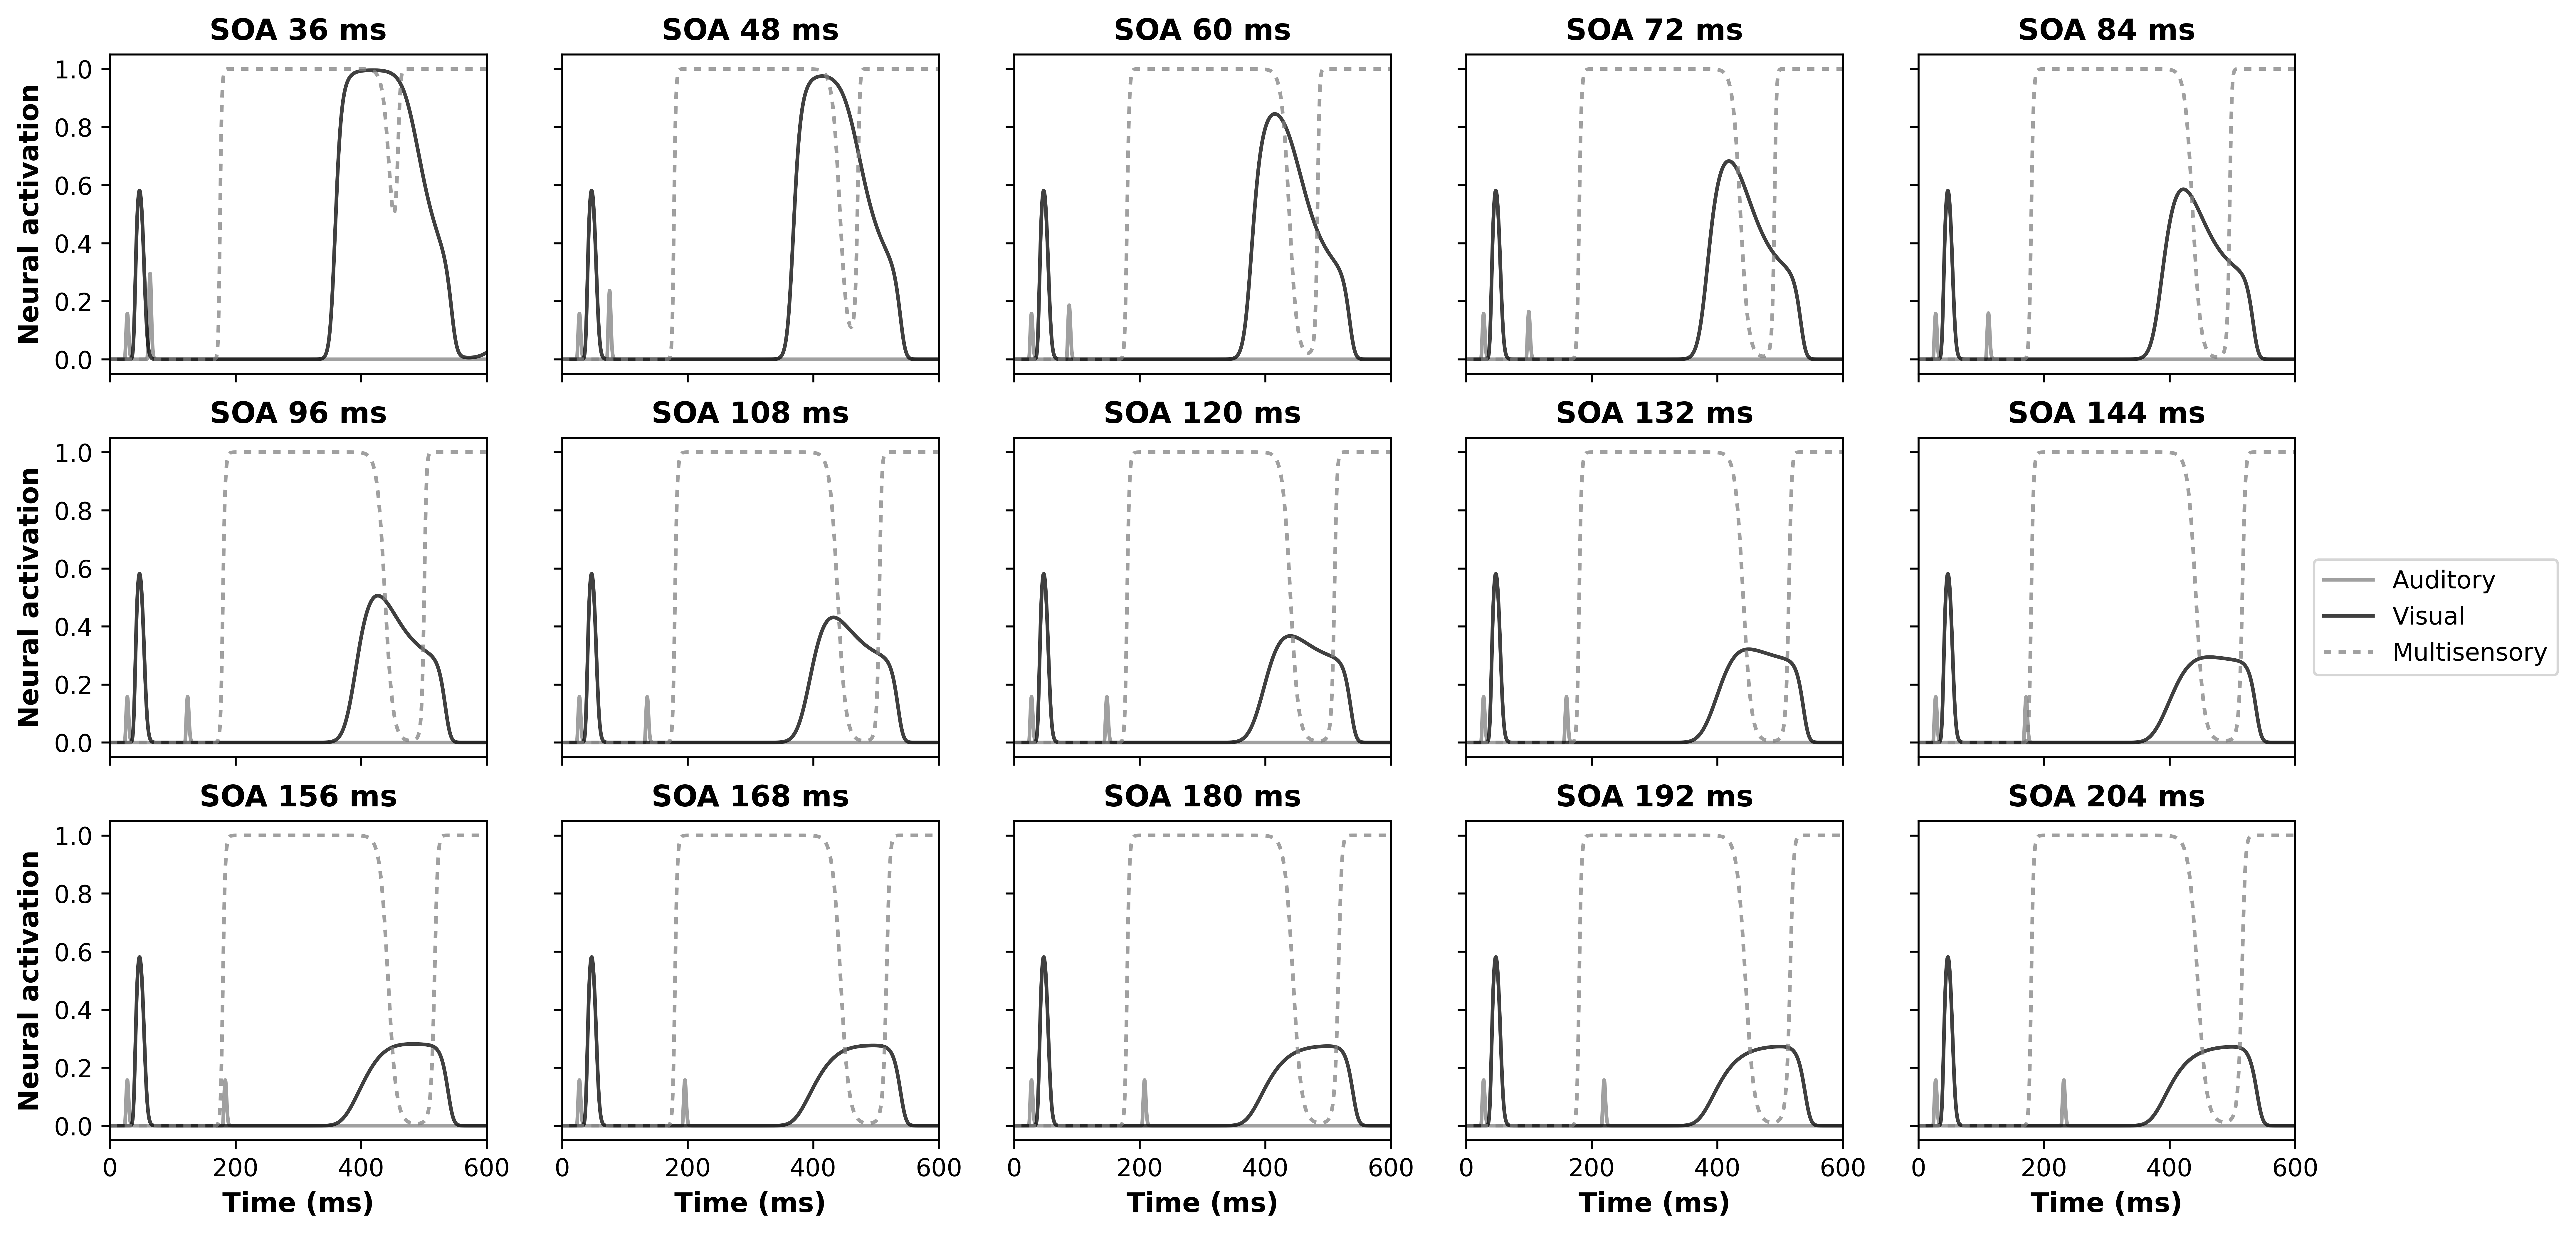

In [16]:
plot_res_per_soa(results_list)